# Segmentation of CHs in synoptic maps

In this notebook we apply a CNN model trained on solar disk images to CHs segmentation
in synoptic maps. 

General imports:

In [1]:
import sys
import numpy as np
from sunpy.visualization.colormaps import color_tables as ct
import tensorflow as tf
from tqdm import tqdm
from astropy import units as u
sdoaia193 = ct.aia_color_table(193*u.angstrom)

sys.path.append('..')
from helio.helio import HelioBatch, FilesIndex, BatchSampler, u_net

First we initialize the CNN model with input shape 256x512 and restore model weights:

In [2]:
PATH_TO_SAVED_MODEL = "../../model_dumps/h_seg_model_24.ckpt"

image_shape = (256, 512, 1)

depth = 4 #Depth of u-net network
init_filters = 24 #Number of filters int the first conv layer

config = tf.ConfigProto()
graph = tf.Graph()
with graph.as_default():
    images = tf.placeholder('float', shape=(None, ) + image_shape, name='images')
    is_training = tf.placeholder(tf.bool, name='is_training')

    predict = u_net(images, depth=depth, init_filters=init_filters,
                    output={'layout': 'ca', 'filters': 1, 'activation': tf.nn.sigmoid},
                    is_training=is_training, verbose=1)
    
    sess = tf.Session(config=config)
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    saver.restore(sess, PATH_TO_SAVED_MODEL)

INFO:tensorflow:Restoring parameters from ../../model_dumps/h_seg_model_24.ckpt


Here we describe proprocessing before application of CNN. First, we fill missing values in synoptic maps with constant value. Then synoptic maps are resized to 360x180 to approximately match pixel sizes with disk images. Then we apply reflection padding to identify prevent splitting of CH that cross0 longitude. Finally, constant padding to 512x256 helps to avoid artefacts near image boundaries.

In [3]:
roi_shape = (180, 360)
r = 10
reflect_pad = np.array([[0, 0], [r, r]])
constant_pad = (np.array(image_shape[:2]) - np.array(roi_shape)) // 2 - reflect_pad.T
constant_pad = constant_pad.T

roi_slice = tuple(slice(x, -x) for x in (np.array(image_shape[:2]) - np.array(roi_shape)) // 2)
 
def preprocess(batch):
    return (batch.load(src='syn', meta='syn')
            .fillna(src='syn', value=1.)
            .resize(src='syn', output_shape=roi_shape, preserve_range=True)
            .flip(src='syn', axis=0) # for FITS data
            .apply(np.pad, src='syn', dst='syn_pad', pad_width=reflect_pad, mode='reflect')
            .apply(np.pad, src='syn_pad', pad_width=constant_pad, mode='constant', constant_values=1)
           )

Index synoptic maps we want to process:

In [4]:
index = FilesIndex(syn='./maps/*.fits')
index.head()

,syn
FilesIndex,
2212,./maps\2212.fits
2213,./maps\2213.fits
2214,./maps\2214.fits


Initialize a batch sampler to iterate over possibly large datasets:

In [5]:
batch_sampler = BatchSampler(index, batch_size=10, n_epochs=1, shuffle=False, drop_incomplete=False)

Run segmentation pipeline. Segmentation maps will be saved in separate FITS files (one can also output results in npz, jpeg, binary, txt and other formats):

In [6]:
for ids in tqdm(batch_sampler):
    batch = preprocess(HelioBatch(ids))
    
    inputs = np.array([np.atleast_3d(x) for x in batch.syn_pad])
    out = sess.run(predict, feed_dict={images: inputs, is_training: False})

    batch.mask = out[:, roi_slice[0], roi_slice[1], 0]
    batch.dump(src='mask', path='./masks/', meta='syn', format='fits', kind='synoptic_mask')

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.72s/it]


Dataset of segmentation maps obtained:

In [7]:
masks = FilesIndex(mask='./masks/*.fits')
masks.head()

,mask
FilesIndex,
2212,./masks\2212.fits
2213,./masks\2213.fits
2214,./masks\2214.fits


Let's load a sample synoptic map and corresponding segmentation map:

In [8]:
batch = HelioBatch(masks.index_merge(index).iloc[[0]]).load(('syn', 'mask'))

Segmentation map shown as a heatmap:

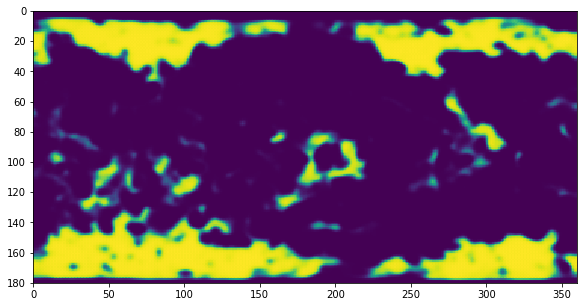

In [9]:
batch.show(0, image='mask', figsize=(10, 5), origin='lower')

Resize segmentation map to shape of synoptic map and show them together:

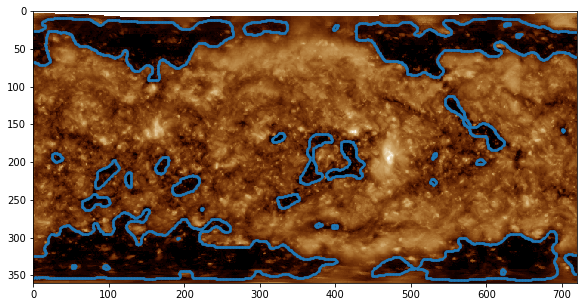

In [10]:
(batch.resize(src='mask', output_shape=(360, 720), preserve_range=True)
 .flip(src=('syn', 'mask'), axis=0)
 .show(0, image='syn', mask='mask', cmap=sdoaia193, figsize=(10, 5), s=2))

Done!